In [1]:
from utils import *

### Baseline, end to end trained model

In [7]:
batch_size = 128
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'mps'
depth = 10

fashion_dataset = FashionMNISTtrainer(batch_size)
params = dict(device=device,
                width=50, lr=0.01, num_train=4,
                sb=1, depth= depth, sw=1.5)

fashion_model = generate_fc_dnn(fashion_dataset.input_dim, fashion_dataset.output_dim,
                params['depth'], params['width']).to(device)

pretrain_acc, pre_trained_model = compute_training_acc_epochs(fashion_model, fashion_dataset, params, debug=True)

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): Tanh()
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): Tanh()
  (4): Linear(in_features=50, out_features=50, bias=True)
  (5): Tanh()
  (6): Linear(in_features=50, out_features=50, bias=True)
  (7): Tanh()
  (8): Linear(in_features=50, out_features=50, bias=True)
  (9): Tanh()
  (10): Linear(in_features=50, out_features=50, bias=True)
  (11): Tanh()
  (12): Linear(in_features=50, out_features=50, bias=True)
  (13): Tanh()
  (14): Linear(in_features=50, out_features=50, bias=True)
  (15): Tanh()
  (16): Linear(in_features=50, out_features=50, bias=True)
  (17): Tanh()
  (18): Linear(in_features=50, out_features=10, bias=True)
  (19): LogSoftmax(dim=1)
) SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

Train set: Average loss: 0.9939, Accuracy: 39408.0/60000 (66%)

Epo

### finetuned staring from regular mnist 

In [4]:
#luckily, the number of classes is the same, so we don't need to change the last layer.

number_dataset = MNISTtrainer(batch_size)

cut_models = []

for cut in range(depth):
    temp = {}
    temp['cut_model'] = cut_model(fashion_model, sw = 1.5, sb = 1, cut_point = cut)
    finetuned_acc, finetuned_model = compute_training_acc_epochs(temp['cut_model'], number_dataset, params, debug=False)
    temp['finetuned_acc'] = finetuned_acc
    temp['finetuned_model'] = finetuned_model
    cut_models.append(temp)   

In [5]:
from pprint import pprint

for i, mod in enumerate(cut_models):
    print(f"Cut {i}:")
    pprint(mod['finetuned_acc'])

Cut 0:
0.8714666666666666
Cut 1:
0.7615666666666666
Cut 2:
0.6475833333333333
Cut 3:
0.5666
Cut 4:
0.3189


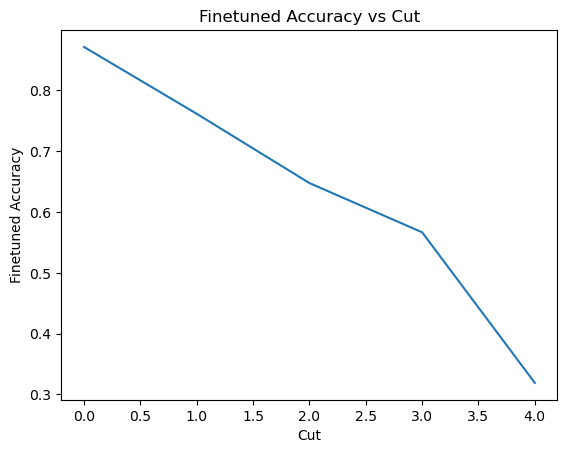

In [6]:
import matplotlib.pyplot as plt

finetuned_accs = [model['finetuned_acc'] for model in cut_models]
cuts = range(len(finetuned_accs))
plt.plot(cuts, finetuned_accs)
plt.xlabel('Cut')
plt.ylabel('Finetuned Accuracy')
plt.title('Finetuned Accuracy vs Cut')
plt.show()

----

In [ ]:
dataset = MNISTtrainer(args.batch_size)
params = dict(device='cpu' if args.no_cuda else 'cuda',
                width=args.width, lr=args.lr, num_train=args.num_train,
                sb=0.05,
    )
if args.debug: print(params)

# run experiment in grid coordinate.
sws = np.linspace(1., 4., args.num_sw)

# test a lot less depths
depths = np.linspace(10, 100, args.num_depth, dtype=int)

pretrain_accs = list()
all_cut_accuracies = list()

for i, depth in enumerate(depths):
    for j, sw in enumerate(sws):
        params['depth'], params['sw'] = depth, sw
        
        # build and initialize the DNN model and optimizer
        model = generate_fc_dnn(dataset.input_dim, dataset.output_dim,
                        params['depth'], params['width']).to(device)
        
        pretrain_acc, pre_trained_model = compute_training_acc(model, dataset, params, debug=False)
        cut_accuracies = calculate_cut_accuracies(model, sw, sb, dataset, params)
        all_cut_accuracies.append(cut_accuracies)
        
        acc = compute_training_acc(dataset, params, debug=args.debug_train_acc)
        pretrain_accs.append(pretrain_acc)
        
        if args.debug: print('({},{})->[d={},sw={}]: \t Train Acc: {:.6f}'.format(i,j,depth,sw,acc))

# acc = np.array(accs).reshape((len(depths), len(sws)))
# np.savez('train_acc', xgrid=sws,ygrid=depths,train_acc=acc)